# Singular Value Decomposition (특이치 분해)
<!-- 9-2 -->


사용 패키지의 로드
- numpy: 행렬 및 선형대수 관련 연산 수행
- matplotlib, matplotlib.pyplot: 시각화 도구
- sklearn.preprocessing.StandardScaler: 데이터 표준화 함수
- sklearn.decomposition.PCA: 주성분분석 도구

 cf) matplotlib.rcParams: 시각화 실행시 설정 변수 (runtime configuration parameter) 변수로 값을 변경함으로써 폰트, 색상등을 조절할 수 있습니다.

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

먼저 이차원 벡터 $v_1 = (v_{11}, \cdots, v_{1p})$, $v_2 = (v_{21}, \cdots, v_{2p})$를 만들어봅시다. 

In [3]:
# --------------- 9-2 SVD --------------- #
### 9-2-1 내적과 각도, 정사영
np.random.seed(0)
p = 2
v1 = np.random.normal(size = p)
v2 = np.random.uniform(size = p)

이 두 벡터를 이용하여 벡터의 연산에 대해서 알아보겠습니다.
- elementwise product
$$ v_1 \circ v_2 = (v_{11}v_{21}, \cdots, v_{1p}v_{2p}) $$
- ($l_2$-)norm
$$\|v_1\| = \sqrt{v_{11}^2 + \cdots v_{1p}^2}$$
- inner product
$$\langle v_1, v_2 \rangle  = v_{11}v_{21} + \cdots + v_{1p}v_{2p}$$

cf)  $\langle v_1, v_2 \rangle =v_1^\top v_2$

In [4]:
# elementwise product
v1 * v2

array([1.06330615, 0.21803893])

In [5]:
# norm
np.sqrt(np.sum(v1 * v1))
np.linalg.norm(v1)

def vec_norm(vec):
    output = np.linalg.norm(vec)
    return output

vec_norm(v1)

1.8088688373462207

In [6]:
# inner product
np.sum(v1 * v2)
np.dot(v1.T, v2)

1.2813450810168578

In [7]:
# innter product를 이용하여 벡터의 norm 계산
np.sqrt(np.dot(v1.T, v1))

1.8088688373462207

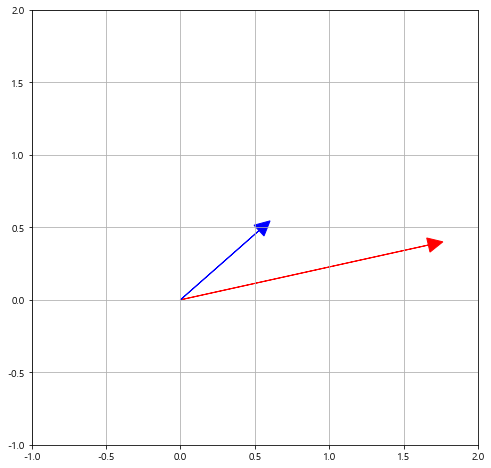

In [8]:
# 두 개의 벡터 그려보기
plt.figure(figsize = (8, 8))
plt.arrow(0 ,0, v1[0], v1[1], head_width = .1, head_length = .1, length_includes_head = True, color = 'red')
plt.arrow(0 ,0, v2[0], v2[1], head_width = .1, head_length = .1, length_includes_head = True, color = 'blue')
plt.xlim(-1, 2)
plt.ylim(-1, 2)
plt.grid()
plt.show()
plt.close()

두 벡터의 유사도는 벡터 차의 길이 (Euclidean distance와 같음), 코사인 유사도를 널리 이용합니다. 코사인 유사도는 각 벡터 길이에 의존하지 않는다는 특징이 있습니다. 여기서는 코사인 유사도를 구해보겠습니다.
$$sim(v_1,v_2) = \frac{\langle v_1, v_2 \rangle}{\|v_1\|\|v_2\|}$$

cf) Cauchy-Schwartz 부등식으로 
\begin{align}
|v_1^\top v_2| \leq \|v_1\|\|v_2\|
\end{align}
이므로 
$$-1 \leq sim(v_1,v_2)\leq 1$$
를 알 수 있다.

In [9]:
# 코사인 유사도
def cosine_similarity(vec1, vec2):
    cosim = np.dot(vec1, vec2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return cosim

In [10]:
cosine_similarity(v1, v2)

0.8717947315508269

v2의 v1위로 정사영(projection)은 다음과 같이 표시합니다.
$$\prod_{\mathcal{C}(v_1)}v_2$$

여기서 $\prod_{\mathcal{C}(v_1)}$는 $v_1$이 생성하는 공간으로 정사영을 만들어주는 행렬(선형변환)이며 $v_2$는 이 선형변환에 대한 입력변수로 간주하면 됩니다. 즉, $v_2$을 $v_1$이 생성하는 공간으로 정사영한 결과가 $\prod_{\mathcal{C}(v_1)}v_2$입니다.

- $v_1 \in \mathbb{R}^n$일 때, 정사영 $\prod_{\mathcal{C}(v_1)}$은 $n\times n$행렬이다.
- 정사영 $\prod_{\mathcal{C}(v_1)}$의 계산
    $$\prod_{\mathcal{C}(v_1)} =v_1(v_1^\top v_1)^{-1}v_1^\top \in \mathbb{R}^{n \times n}$$

In [38]:
n = 5
np.random.seed(1)
v1 = np.random.normal(size = (n,1))
v1@np.linalg.inv(v1.T@v1)@v1.T

array([[ 0.50819493, -0.19139495, -0.16524454, -0.33569044,  0.27075262],
       [-0.19139495,  0.07208263,  0.06223394,  0.1264268 , -0.1019701 ],
       [-0.16524454,  0.06223394,  0.05373088,  0.10915302, -0.08803786],
       [-0.33569044,  0.1264268 ,  0.10915302,  0.22174183, -0.17884686],
       [ 0.27075262, -0.1019701 , -0.08803786, -0.17884686,  0.14424973]])

In [34]:
# 정사영
# v2의 v1위로 정사영
def proj_map(v: np.array):
    try:
        if len(v.shape)!=2:                                
            raise Exception('행렬인 변수를 사용하여야 합니다.')
    except Exception as e:
        print('예외가 발생했습니다.', e)
    proj = v@np.linalg.inv(v.T@v)@v.T
    return proj

In [35]:
proj_map(v1)

array([[0.22647574, 0.12951161, 0.2400925 , 0.12837338, 0.29032239],
       [0.12951161, 0.07406205, 0.13729844, 0.07341114, 0.16602272],
       [0.2400925 , 0.13729844, 0.25452796, 0.13609177, 0.3077779 ],
       [0.12837338, 0.07341114, 0.13609177, 0.07276596, 0.16456361],
       [0.29032239, 0.16602272, 0.3077779 , 0.16456361, 0.3721683 ]])

In [40]:
v2 = np.random.normal(size = (n,1))
proj_vec = proj_map(v1)@v2
proj_vec

array([[ 1.62650849],
       [-0.61257108],
       [-0.52887511],
       [-1.07439748],
       [ 0.86656008]])

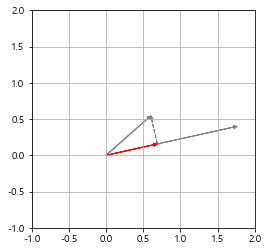

In [55]:
p = 2
np.random.seed(0)
v1 = np.random.normal(size = (p,1))
v2 = np.random.uniform(size = (p,1))
plt.figure(figsize = (4, 4))
plt.arrow(0 ,0, v1[0,0], v1[1,0], head_width = .05, head_length = .05, 
          length_includes_head = True, color = 'gray')
plt.arrow(0 ,0, v2[0,0], v2[1,0], head_width = .05, head_length = .05, 
          length_includes_head = True, color = 'gray')
# projection 
proj_vec = proj_map(v1)@v2
plt.arrow(0, 0, proj_vec[0,0], proj_vec[1,0], head_width = .05, head_length = .05, 
          length_includes_head = True, color = 'red')
plt.arrow(proj_vec[0,0], proj_vec[1,0], v2[0,0]-proj_vec[0,0], v2[1,0]-proj_vec[1,0], 
          head_width = .05, head_length = .05, length_includes_head = True, 
          color = 'gray', linestyle = 'dashed')
plt.xlim(-1, 2)
plt.ylim(-1, 2)
plt.grid()
plt.show()
plt.close()

앞서 살펴보았듯이 행렬은 선형변환으로 볼 수 있다. 행렬의 곱은 선형변환의 합성(composition)으로 볼 수 있는데 아래 예를 통해 살펴보자.
- mat: $2\times 2$행렬

In [59]:
### 9-2-2 선형변환으로서 직교행렬과 대각행렬
np.random.seed(0)
n = 2
M = np.random.normal(size = (n, n))

In [ ]:
# 대각행렬
D = np.identity(n)
MD = M @ D
print(f'original matrix: \n{M} \ntransformed matrix:\n{MD}')

original matrix: 
[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]] 
transformed matrix:
[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]]


아래 예제를 통해서 원행렬 $\circ$ 대각행렬의 합성은 원행렬의 열벡터를 대각원소의 값 만큼 scaling한다는 것을 확인할 수 있습니다.

In [69]:
D = np.diag([0.5, 2])
MD = M @ D
print(f'original matrix: \n{M} \ntransformed matrix:\n{MD}')

original matrix: 
[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]] 
transformed matrix:
[[0.88202617 0.80031442]
 [0.48936899 4.4817864 ]]


In [68]:
# 직교행렬
A = np.array([1, 2, 3, 5]).reshape(2, 2)
q, r = np.linalg.qr(A)
print("A matrix:\n", A)
print("Q matrix:\n", q)
print("R matrix:\n", r)
print("Q@R is A:\n", q@r)

A matrix:
 [[1 2]
 [3 5]]
Q matrix:
 [[-0.31622777 -0.9486833 ]
 [-0.9486833   0.31622777]]
R matrix:
 [[-3.16227766 -5.37587202]
 [ 0.         -0.31622777]]
Q@R is A:
 [[1. 2.]
 [3. 5.]]


위에서 사용한 'np.linalg.qr()'는 어떤 정방행렬 $A$를 두개의 행렬의 곱으로 표현해주는 함수입니다. 이 과정은 QR-decomposition 을 수행하는 것인데, 여기서 Q,R은 특별한 성질을 만족한다.
- R: 상삼각행렬 (upper-triangular matrix)
- Q: 직교행렬 (orthogonal matrix)
    - 각 열벡터의 길이가 1이고 열벡터들간 내적이 0인 행렬 ($Q^{-1} = Q^{T}$가 성립함)

In [71]:
print("Q is orthogonal matrix:\n", q @ q.T)

Q is orthogonal matrix:
 [[ 1.00000000e+00 -5.84964249e-17]
 [-5.84964249e-17  1.00000000e+00]]


In [73]:
np.random.seed(0)
A = np.random.normal(size=(3,3))
q, r = np.linalg.qr(A)

위 예제에서 얻어진 $q$행렬이 직교행렬임을 확인해보아라.
- 각 열벡터의 길이가 1인가?
- 열벡터들간 내적이 0인 행렬인가?

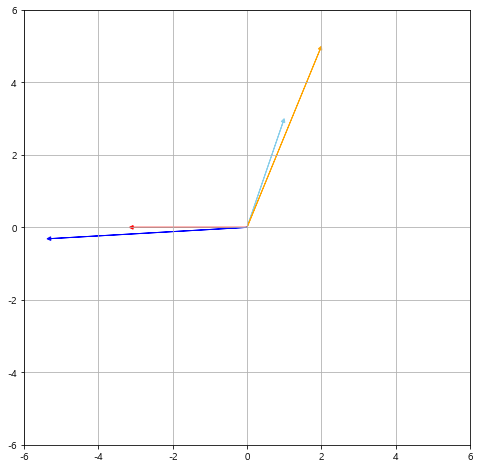

original matrix: 
[[1 2]
 [3 5]] 
transformed matrix:
[[-3.16227766e+00 -5.37587202e+00]
 [ 3.88578059e-16 -3.16227766e-01]]


In [23]:
trans_mat4 = q @ mat2

plt.figure(figsize = (8, 8))
plt.arrow(0 ,0, mat2[:, 0][0], mat2[:, 0][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'skyblue')
plt.arrow(0 ,0, mat2[:, 1][0], mat2[:, 1][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'orange')
plt.arrow(0 ,0, trans_mat4[:, 0][0], trans_mat4[:, 0][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'red')
plt.arrow(0 ,0, trans_mat4[:, 1][0], trans_mat4[:, 1][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'blue')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.grid()
plt.show()
plt.close()

print(f'original matrix: \n{mat2} \ntransformed matrix:\n{trans_mat4}')

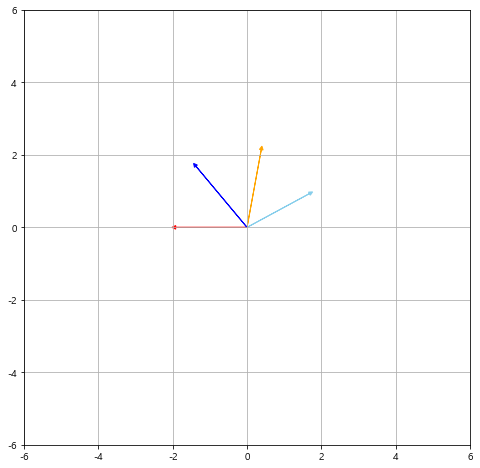

original matrix: 
[[1 2]
 [3 5]] 
transformed matrix:
[[-3.16227766e+00 -5.37587202e+00]
 [ 3.88578059e-16 -3.16227766e-01]]


In [24]:
q, r = np.linalg.qr(mat)
q @ q.T

trans_mat5 = q @ mat
# trans_mat5 = q.T @ mat @ q

plt.figure(figsize = (8, 8))
plt.arrow(0 ,0, mat[:, 0][0], mat[:, 0][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'skyblue')
plt.arrow(0 ,0, mat[:, 1][0], mat[:, 1][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'orange')
plt.arrow(0 ,0, trans_mat5[:, 0][0], trans_mat5[:, 0][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'red')
plt.arrow(0 ,0, trans_mat5[:, 1][0], trans_mat5[:, 1][1], head_width = .1, head_length = .1, length_includes_head = True, color = 'blue')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.grid()
plt.show()
plt.close()

print(f'original matrix: \n{mat2} \ntransformed matrix:\n{trans_mat4}')

In [ ]:


### 9-2-3 행렬의 특이치 분해
n = 10
p = 2

seed = 0
np.random.seed(seed)

x = np.random.normal(size = (n, p))
u, s, vh= np.linalg.svd(x, full_matrices=False)
u.shape
s.shape
vh.shape

# UDV^T 에서 V^T matrix를 확인
# V행렬의 열벡터는 직교함
(vh[0,:]*vh[1,:]).sum()

# 0번 obs의 표현형
u[0,:]

# scaled
plt.plot(u[:,0],u[:,1], '.')

# considering the size s
plt.plot(s[0]*u[:,0],s[1]*u[:,1], '.')

# approximation
k = 1
x_approx = u[:,:k]@np.diag(s[:k])@vh[:k,:]
print( np.mean((x-x_approx)**2) )

# 주성분 값을 이용한 데이터의 재표현
x
u@np.diag(s)@vh

# x^T
x.T
vh.T@(np.diag(s)).T@u.T

#
x.T@x
vh.T@(np.diag(s)).T@u.T@u@(np.diag(s))@vh

# covariance
(x - np.mean(x, axis = 0)).T@(x - np.mean(x, axis = 0))/x.shape[0]
covmat = np.cov(x, rowvar = False, bias = True)
covmat

centered_x = np.zeros_like(x)
for i in range(x.shape[1]):
    centered_x[:, i] = x[:, i] - np.mean(x[:, i])

u, s, vh= np.linalg.svd(centered_x, full_matrices=False)
vh.T@(np.diag(s)).T@u.T@u@(np.diag(s))@vh
covmat

